In [41]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/predicted_outcomes/bnm_closeness.csv'
sheet = None #'master_list_proper_subjects' ?

In [42]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=None, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,Unnamed__0,patient_id,actual_score,dice,optimizer,pred_score,predictions
0,0,Pat1,12.500000,0.398707,0,NaN,-5.618880
1,1,Pat2,-17.391304,0.420174,0,NaN,-3.668437
2,2,Pat3,-26.086957,0.305130,0,NaN,-14.120869
3,3,Pat5,6.896552,0.548886,0,NaN,8.025671
4,4,Pat6,5.555556,0.367914,0,NaN,-8.416569
5,5,Pat7,36.363636,0.640675,0,NaN,16.365255
6,6,Pat8,-11.111111,0.520905,0,NaN,5.483454
7,7,Pat9,17.500000,0.748665,0,NaN,26.176746
8,8,Pat1,0.000000,1.000000,1,NaN,49.011838
9,9,Pat2,0.000000,1.000000,1,NaN,49.011838



# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
len(data_df['study'].unique())

In [ ]:
data_df.columns

In [ ]:
drop_list = ['all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_target_in_subject', 'Overall_Cognition_Cohen_s_D']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [3]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'actual_score', 'dice', 'optimizer',
       'pred_score', 'predictions'],
      dtype='object')

In [ ]:
data_df.Disease.unique()

In [ ]:
column = 'Memory_Specific'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 0 # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

In [ ]:
data_df_sorted = data_df.sort_values(by='Location')
data_df_sorted

Regress out Covariates

In [ ]:
data_df.columns

In [ ]:
dependent_variable_list = ['Pre_Post_Memory_Effect_Size__Cohen_s_D_']
regressors = ['Disease', 'Years_Between_Measurements', 'Mean_Age', 'Closed_Loop']

In [ ]:
#Impute covariates in if desired
for col in regressors:
    if data_df[col].dtype == 'O':  # object/categorical
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  # numeric
        data_df[col] = data_df[col].fillna(data_df[col].mean())
data_df[regressors].isna().sum()

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)

Do Miscellaneous Data Cleaning

In [4]:
# data_df = data_df[(data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] >= -1) & (data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] <= 1)]

In [5]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'actual_score', 'dice', 'optimizer',
       'pred_score', 'predictions'],
      dtype='object')

In [10]:
import numpy as np
data_df['spcorr_sign'] = np.where(data_df['all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_target_in_subject'] > 0, 'Positive', 'Negative')


# A - Simple BoxPLot

In [28]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'score', 'average_dice_coefficient',
       'optimizer', 'predictions'],
      dtype='object')

In [29]:
category_col = 'optimizer'
y_col = 'predictions'

In [ ]:
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Academia/Research/2023/ccm_memory/Figures/explaining_prior_targets_alzheimer'

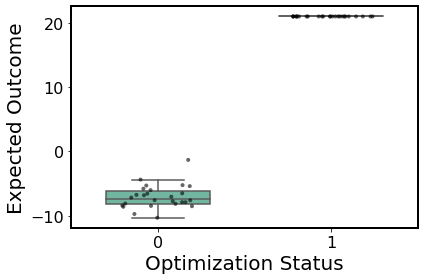

In [31]:
from calvin_utils.statistical_utils.boxplot import BoxJitterPlotter
bjp = BoxJitterPlotter(figsize=(6,4))
bjp.plot(data_df, group_col=category_col, y_col=y_col, title='', out_dir=out_dir, xlabel='Optimization Status', ylabel="Expected Outcome")

In [ ]:
from scipy.stats import ttest_ind

# Get the unique groups
groups = data_df[category_col].unique()
if len(groups) != 2:
    raise ValueError("T-test requires exactly two groups.")

# Split the data by group
group1 = data_df[data_df[category_col] == groups[0]][y_col].dropna()
group2 = data_df[data_df[category_col] == groups[1]][y_col].dropna()

# Run independent t-test


T-statistic: -9.5829, p-value: 2.8311e-05


/Users/cu135/.virtualenvs/Python_3.7.7_nimlab/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'score', 'average_dice_coefficient',
       'optimizer', 'predictions'],
      dtype='object')

In [36]:
import numpy as np
np.std(obs.values-pred.values)

6.284784857897618

In [37]:
len(obs)

26

In [44]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'actual_score', 'dice', 'optimizer',
       'pred_score', 'predictions'],
      dtype='object')

In [45]:
obs = data_df[data_df['optimizer'] == 0]['actual_score']
pred = data_df[data_df['optimizer'] == 1]['predictions']

t_stat, p_value = ttest_ind(obs, pred, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

T-statistic: -6.3940, p-value: 3.6938e-04


/Users/cu135/.virtualenvs/Python_3.7.7_nimlab/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [46]:
import numpy as np
from scipy.stats import t

# Means and standard deviations for the two groups
mean1 = np.mean(obs)
std1 = np.std(obs)
n1 = len(group1)

mean2 = 21
std2 = 21/np.sqrt(26)
n2 = len(group2)

# Calculate t-statistic for independent samples (unequal variance)
se = np.sqrt(std1**2 / n1 + std2**2 / n2)
t_stat_manual = (mean1 - mean2) / se

# Degrees of freedom (Welch-Satterthwaite equation)
df = (std1**2 / n1 + std2**2 / n2)**2 / (
    (std1**2 / n1)**2 / (n1 - 1) + (std2**2 / n2)**2 / (n2 - 1)
)

# Two-tailed p-value
p_value_manual = 2 * t.sf(np.abs(t_stat_manual), df)

print(f"Manual t-statistic: {t_stat_manual:.4f}, p-value: {p_value_manual:.4e}")

Manual t-statistic: -2.6110, p-value: 3.2262e-02


In [9]:
(( (25*(105)**2) + (8 * 48**2) ) / 33)**0.5 / (35)**0.5

15.956027237216825

In [4]:
16 * (9**0.5)

48.0

# B - Horizontal Box Plot
- Import a CSV with labels in the first column and observations across the other columns. Each row gets a boxplot. 

In [ ]:
data_path =''

In [ ]:
import pandas as pd
df = pd.read_csv(data_path)

In [ ]:
from calvin_utils.statistical_utils.boxplot import plot_horizontal_boxplot_with_stats
plot_horizontal_boxplot_with_stats(
    df,
    xlabel="x",
    out_dir=out_dir
)

Simple boxplot from CSV